In [11]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = 'sh-fe080851-d462-4304-9f4d-1b7fd7c7dc95'
config.sh_client_secret = 'XBnxUPfjs1duw9wmexDpoVmhTbY6piHw'
config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'

In [12]:
import datetime
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.transform import from_bounds
from pathlib import Path
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)


In [13]:
hyd_coords_wgs84 = (78.00405826,16.93264351,79.04971836,17.90150706)
resolution=(7000, 3500)
hyd_bbox = BBox(bbox=hyd_coords_wgs84, crs=CRS.WGS84)
hyd_size = bbox_to_dimensions(hyd_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {hyd_size} pixels")

Image shape at (7000, 3500) m resolution: (16, 30) pixels


In [14]:
evalscript_mean_mosaic = """
//VERSION=3
function setup() {
    return {
        input: ["CO", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "ORBIT"
    };
}

function isClear(sample) {
    return sample.dataMask == 1;
}

function sum(array) {
    let sum = 0;
    for (let i = 0; i < array.length; i++) {
        sum += array[i].CO;
    }
    return sum;
}

function evaluatePixel(samples) {
    const clearTs = samples.filter(isClear)
    const mean = sum(clearTs) / clearTs.length
    return [mean]
}
"""

In [15]:
def get_data(time_interval):
    request = SentinelHubRequest(
        evalscript=evalscript_mean_mosaic,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL5P.define_from(
                    "s5pl2", service_url=config.sh_base_url
                ),
                time_interval=time_interval,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=hyd_bbox,
        size=hyd_size,
        config=config,
        data_folder="./data/CO_3",
    )
    raw_data = request.get_data(save_data=True)
    return raw_data[0]

In [47]:
get_data(("2022-12-1","2022-12-30"))

array([[0.03847224, 0.03851694, 0.03759533, 0.03809786, 0.03737785,
        0.03660254, 0.03745275, 0.03736618, 0.03686514, 0.03661023,
        0.03709045, 0.0375979 , 0.03663367, 0.03712772, 0.03760685,
        0.03740032],
       [0.03829834, 0.0380131 , 0.03721236, 0.03779124, 0.03700907,
        0.03671939, 0.03704252, 0.03696753, 0.03709831, 0.03686945,
        0.03707515, 0.03700792, 0.03663383, 0.03684472, 0.03719339,
        0.03784427],
       [0.03797423, 0.03757676, 0.03723663, 0.03720456, 0.03736501,
        0.03636191, 0.03681292, 0.03715546, 0.03748849, 0.03734448,
        0.03604215, 0.03744631, 0.03647229, 0.03711036, 0.03765846,
        0.03834536],
       [0.03757204, 0.03792314, 0.03776768, 0.03781558, 0.03737798,
        0.03623119, 0.03644655, 0.03718721, 0.03700482, 0.03688567,
        0.03600743, 0.03716744, 0.03670253, 0.03769227, 0.03775881,
        0.03841077],
       [0.03779203, 0.0380379 , 0.03747863, 0.03777523, 0.03770364,
        0.03693363, 0.03636387, 

In [17]:
# months = {
#     1: ("January", 31),
#     2: ("February", 28),
#     3: ("March", 31),
#     4: ("April", 30),
#     5: ("May", 31),
#     6: ("June", 30),
#     7: ("July", 31),
#     8: ("August", 31),
#     9: ("September", 30),
#     10: ("October", 31),
#     11: ("November", 30),
#     12: ("December", 31)
# }
# vals=[]
# output_dir=r"C:\Users\rishi\ml_projects\climate\2019_data\CO"
# for i in range(1,13):
#     month_name, end_day = months[i]
#     start=f"2019-{i}-1"
#     end = f"2019-{i}-{end_day}"
#     time_interval=(start,end)
#     arr=get_data(time_interval)
#     path=os.path.join(output_dir, f'{month_name}_SO2.csv')
#     np.savetxt(path, arr, delimiter=',')

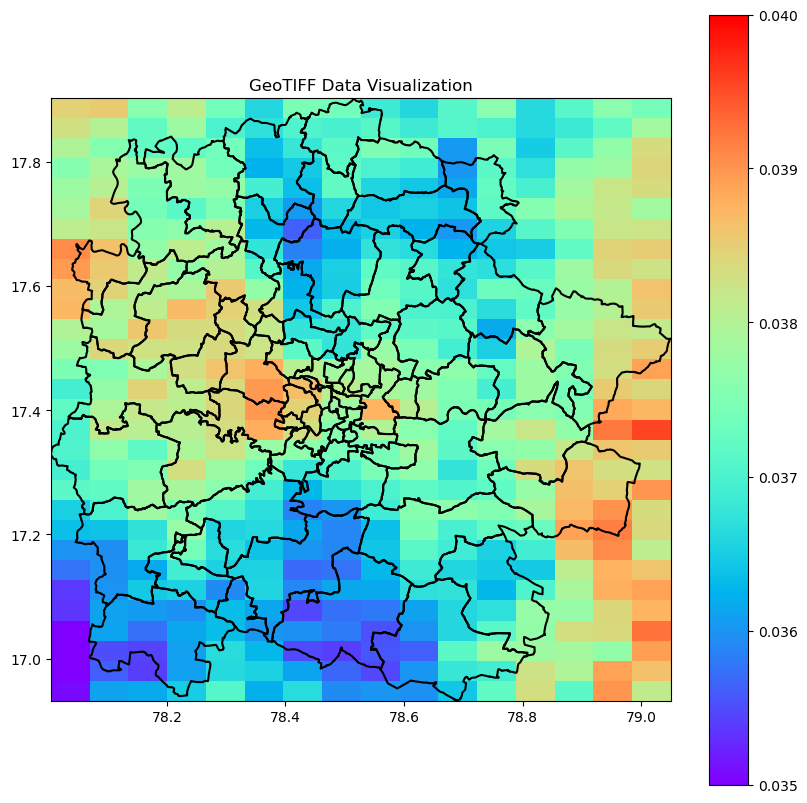

In [61]:
import geopandas as gpd

# Load the shapefile
shapefile_path = r'C:\Users\rishi\ml_projects\climate\hmda_boundary\hmda_boundary.shp'
gdf = gpd.read_file(shapefile_path)

import rasterio
from rasterio.plot import show

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Load the GeoTIFF file
vmin = .035  # Minimum value for normalization
vmax = .04  # Maximum value for normalization

# Open the GeoTIFF file
tiff_file = r'C:\Users\rishi\ml_projects\climate\data\CO_3\3c3bf4ff9d51e7371026a1a201b6a7e9\response.tiff'
with rasterio.open(tiff_file) as dataset:
    # Create a normalization instance
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    
    # Display the image with geospatial context
    fig, ax = plt.subplots(figsize=(10, 10))
    show(dataset, ax=ax, cmap='rainbow', norm=norm)
    plt.title('GeoTIFF Data Visualization')
    
    # Add a colorbar with the same normalization
    plt.colorbar(ax.images[0], ax=ax, orientation='vertical')
    
    # Plot the boundary of the GeoDataFrame
    gdf.boundary.plot(ax=ax, edgecolor='black')
    
    plt.show()

In [62]:
with rasterio.open(tiff_file) as dataset:
    # Print metadata
    print(dataset.meta)
    num_bands = dataset.count
    print(f"The GeoTIFF file has {num_bands} band(s).")
    # Get the spatial extent (bounding box)
    print("Bounds:", dataset.bounds)
    
    # Read the data as a numpy array (e.g., first band)
    data = dataset.read(1)
    print("Data shape:", data.shape)
    print(data)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 16, 'height': 30, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0653537562500004, 0.0, 78.00405826,
       0.0, -0.032295451666666725, 17.90150706)}
The GeoTIFF file has 1 band(s).
Bounds: BoundingBox(left=78.00405826, bottom=16.93264351, right=79.04971836, top=17.90150706)
Data shape: (30, 16)
[[0.03847224 0.03851694 0.03759533 0.03809786 0.03737785 0.03660254
  0.03745275 0.03736618 0.03686514 0.03661023 0.03709045 0.0375979
  0.03663367 0.03712772 0.03760685 0.03740032]
 [0.03829834 0.0380131  0.03721236 0.03779124 0.03700907 0.03671939
  0.03704252 0.03696753 0.03709831 0.03686945 0.03707515 0.03700792
  0.03663383 0.03684472 0.03719339 0.03784427]
 [0.03797423 0.03757676 0.03723663 0.03720456 0.03736501 0.03636191
  0.03681292 0.03715546 0.03748849 0.03734448 0.03604215 0.03744631
  0.03647229 0.03711036 0.03765846 0.03834536]
 [0.03757204 0.03792314 0.03776768 0.03781558 0.03737798 0.03623119
  0.036